In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import functions.token_functions as tf
import spacy
import pickle
import torch
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import LinearSVC
from sklearn.utils import resample
from transformers import BertConfig, BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, SequentialSampler, DataLoader, RandomSampler
from tqdm import trange, notebook
from nltk.corpus import stopwords

In [2]:
nlp = spacy.load('en_core_web_sm')
sw = stopwords.words("english")

In [3]:
# Create an empty list to store the review dataframes
df_list = []

for root, dirs, files in os.walk('../data'):
    for filename in files:
        # Read the CSV file into a datadrame
        df = pd.read_csv(os.path.join(root, filename), index_col=0)

        # Append the dataframe to the list
        df_list.append(df)

# Combine the dataframes into a single dataframe
nlp_df = pd.concat(df_list, ignore_index=True)

In [4]:
# drop titles
nlp_df = nlp_df.drop(columns=['game_title','movie_title'])

# drop values
nlp_df = nlp_df.dropna()

# drop non english reviews
nlp_df['lang'] = nlp_df['review'].apply(tf.detect_language)

nlp_df = nlp_df.query('lang == "en"')

# convert review from float to int
nlp_df['rating'] = nlp_df['rating'].astype(int)

In [5]:
nlp_df['review_tokens'] = nlp_df['review'].apply(tf.clean_tokenize)
nlp_df['review_title_tokens'] = nlp_df['review_title'].apply(tf.clean_tokenize)

In [6]:
nlp_df.groupby(['rating'])['review'].count()

rating
1     6480
2     3898
3     6459
4    12775
5    91526
Name: review, dtype: int64

In [7]:
nlp_df['sentiment'] = 0
nlp_df.loc[nlp_df['rating']>3, 'sentiment'] = 1
nlp_df.loc[nlp_df['rating']<3, 'sentiment'] = 0

<AxesSubplot:xlabel='sentiment', ylabel='count'>

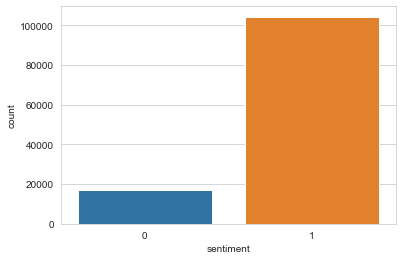

In [8]:
sns.countplot(x=nlp_df['sentiment'])

<AxesSubplot:xlabel='rating', ylabel='count'>

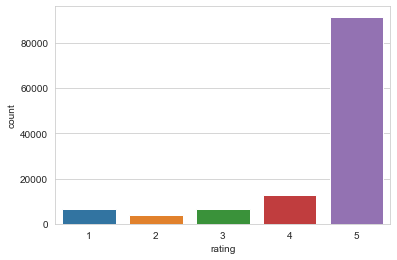

In [9]:
sns.countplot(x=nlp_df['rating'])

In [10]:
no_5 = nlp_df.query('rating != 5')
just_5 = nlp_df.query('rating == 5')

In [11]:
adjusted_5 = resample(just_5,
                      replace=False,
                      n_samples=15000,
                      random_state=10)

In [12]:
adj_nlp_df = pd.concat([adjusted_5, no_5])

<AxesSubplot:xlabel='sentiment', ylabel='count'>

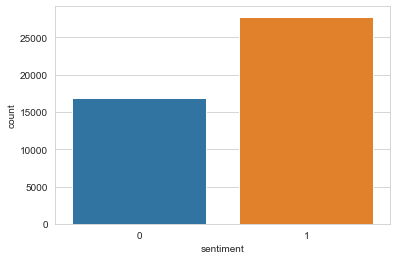

In [13]:
sns.countplot(x=adj_nlp_df['sentiment'])


<AxesSubplot:xlabel='rating', ylabel='count'>

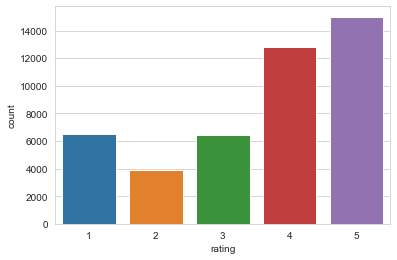

In [14]:
sns.countplot(x=adj_nlp_df['rating'])

## Split Data

In [15]:
X_train, X_test, y_train, y_test = train_test_split(adj_nlp_df['review'], adj_nlp_df['sentiment'], test_size=0.20, random_state=10, stratify=adj_nlp_df['sentiment'])

In [16]:
tf.sentiment_stats(X_train, X_test, y_train, y_test)

Size of Training Data  35689
Size of Test Data  8923
Distribution of classes in Training Data :
Positive Sentiment  62.2600801367368
Negative Sentiment  37.73991986326319
Distribution of classes in Testing Data :
Positive Sentiment  62.25484702454332
Negative Sentiment  37.74515297545668


## Vectorize Data

In [17]:
tfidf = TfidfVectorizer(min_df = 20, max_df=.2 ,ngram_range=(1,1),stop_words=sw)
X_train_tf = tfidf.fit_transform(X_train)
X_test_tf = tfidf.transform(X_test)
X_train_tf.shape

(35689, 4536)

## Train SVG Sentiment Model

In [18]:
svc_model = LinearSVC(random_state=10, tol=1e-5)
svc_model.fit(X_train_tf, y_train)

LinearSVC(random_state=10, tol=1e-05)

In [19]:
y_pred = svc_model.predict(X_test_tf)

print ('Accuracy Score - ', accuracy_score(y_test, y_pred))
print ('Precision - ', precision_score(y_test, y_pred, average='macro'))
print ('Recall - ', recall_score(y_test, y_pred, average='macro'))
print ('F1 Score - ', f1_score(y_test, y_pred, average='macro'))

Accuracy Score -  0.8381710187156786
Precision -  0.829989175025218
Recall -  0.8227433343096779
F1 Score -  0.8259881666445362


## Train Pytorch Model

In [20]:
config = BertConfig.from_pretrained('bert-base-uncased',finetuning_task='binary')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [21]:
X_train_tokens = X_train.apply(tf.get_tokens, args=(tokenizer, 50))
X_test_tokens = X_test.apply(tf.get_tokens, args=(tokenizer, 50))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\Ivan\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
C:\Users\Ivan\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2377: FutureWar

In [22]:
input_ids_train = torch.tensor([features[0] for features in X_train_tokens.values], dtype=torch.long)
input_mask_train = torch.tensor([features[1] for features in X_train_tokens.values], dtype=torch.long)
label_ids_train = torch.tensor(y_train.values, dtype=torch.long)
train_dataset = TensorDataset(input_ids_train, input_mask_train, label_ids_train)

In [23]:
input_ids_test = torch.tensor([features[0] for features in X_test_tokens.values],dtype=torch.long)
input_mask_test = torch.tensor([features[1] for features in X_test_tokens.values],dtype=torch.long)
label_ids_test = torch.tensor(y_test.values,dtype=torch.long)
test_dataset = TensorDataset(input_ids_test, input_mask_test, label_ids_test)

In [24]:
train_batch_size = 64
num_train_epochs = 2
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset,sampler=train_sampler,batch_size=train_batch_size)
t_total = len(train_dataloader) // num_train_epochs
print ("Num examples = ", len(train_dataset))
print ("Num Epochs = ", num_train_epochs)
print ("Total train batch size = ", train_batch_size)
print ("Total optimization steps = ", t_total)

Num examples =  35689
Num Epochs =  2
Total train batch size =  64
Total optimization steps =  279


In [25]:
learning_rate = 1e-4
adam_epsilon = 1e-8
warmup_steps = 0
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=adam_epsilon)
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=warmup_steps,num_training_steps=t_total)

C:\Users\Ivan\anaconda3\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_iterator = trange(num_train_epochs, desc="Epoch")

# Put model in 'train' mode
model.train()
for epoch in train_iterator:
    epoch_iterator = notebook.tqdm(train_dataloader, desc="Iteration")
    for step, batch in enumerate(epoch_iterator):
        # Reset all gradients at start of every iteration
        model.zero_grad()
        # Put the model and the input observations to GPU
        model.to(device)
        batch = tuple(t.to(device) for t in batch)
        # Identify the inputs to the model
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}
        # Forward Pass through the model. Input -> Model -> Output
        outputs = model(**inputs)
        # Determine the deviation (loss)
        loss = outputs[0]
        print("\r%f" % loss, end='')
        # Back-propogate the loss (automatically calculates gradients)
        loss.backward()
        # Prevent exploding gradients by limiting gradients to 1.0
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # Update the parameters and learning rate
        optimizer.step()
        scheduler.step()

# Save trained model
model.save_pretrained('../models/torch_outputs')

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/558 [00:00<?, ?it/s]

0.308797

Epoch:  50%|█████     | 1/2 [01:52<01:52, 112.97s/it]

Iteration:   0%|          | 0/558 [00:00<?, ?it/s]

0.283575

Epoch: 100%|██████████| 2/2 [03:34<00:00, 107.03s/it]

0.136610

In [27]:
test_batch_size = 64
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset,
                             sampler=test_sampler,
                             batch_size=test_batch_size)

# Load the pre-trained model if needed
# model = model.from_pretrained('/outputs')

# Initialize the prediction and actual labels
preds = None
out_label_ids = None

## Put model in "eval" mode
model.eval()

for batch in notebook.tqdm(test_dataloader, desc="Evaluating"):

    ## Put the model and the input observations to GPU
    model.to(device)
    batch = tuple(t.to(device) for t in batch)

    ## Do not track any gradients since in 'eval' mode
    with torch.no_grad():
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2]}

        ## Forward pass through the model
        outputs = model(**inputs)

        ## We get loss since we provided the labels
        tmp_eval_loss, logits = outputs[:2]

        ## There maybe more than one batch of items in the test dataset
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = inputs['labels'].detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(out_label_ids,
                                      inputs['labels'].detach().cpu().numpy(),
                                      axis=0)

## Get final loss, predictions and accuracy
preds = np.argmax(preds, axis=1)
acc_score = accuracy_score(preds, out_label_ids)
print ('Accuracy Score on Test data ', acc_score)

Evaluating:   0%|          | 0/140 [00:00<?, ?it/s]

Accuracy Score on Test data  0.8779558444469349


## Sample Predictions

## SVG Model

In [28]:
sample_reviews = nlp_df.sample(5)
sample_reviews_tf = tfidf.transform(sample_reviews['review'])
sentiment_predictions = svc_model.predict(sample_reviews_tf)
sentiment_predictions = pd.DataFrame(data = sentiment_predictions,
                                     index=sample_reviews.index,
                                     columns=['sentiment_prediction'])
sample_reviews = pd.concat([sample_reviews, sentiment_predictions], axis=1)
print ('Some sample reviews with their sentiment - ')
sample_reviews[['review','sentiment_prediction']]

Some sample reviews with their sentiment - 


,review,sentiment_prediction
36114,This book grabbed me from the very beginning a...,1
34659,Bought this book as a gift and he absolutely l...,1
63099,"Loved this book, finished in 2 days.\nLearned ...",1
5764,"I was reading this book to my students, withou...",1
100704,I loved this book from beginning to end! There...,1


In [29]:
text = ['This game is okay']
test = tfidf.transform(text)
test_pred = svc_model.predict(test)

test_pred

array([0], dtype=int64)

## Pytorch Model

In [30]:
# Preprocess the sample review
sample_review = "This game is good"


# Convert preprocessed text to PyTorch tensors
input_ids, attention_mask = tf.get_tokens(sample_review, tokenizer, 50)
input_tensor = torch.tensor(input_ids, dtype=torch.long).unsqueeze(0)  # Assuming batch size of 1
attention_mask_tensor = torch.tensor(attention_mask, dtype=torch.long).unsqueeze(0)  # Assuming batch size of 1


# Make the prediction
model.eval()
with torch.no_grad():
    input_tensor = input_tensor.to(device)
    attention_mask_tensor = attention_mask_tensor.to(device)
    outputs = model(input_ids=input_tensor, attention_mask=attention_mask_tensor)
    predicted_class = torch.argmax(outputs.logits, dim=1)

print("Predicted class:", predicted_class.item())


Predicted class: 1


C:\Users\Ivan\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


## Pickle Models

In [31]:
with open('../models/svc_model.pkl', 'wb') as file:
    pickle.dump(svc_model, file)

with open('../models/tfidf.pkl', 'wb') as file:
    pickle.dump(tfidf, file)